# The BASELINE model

## Imports

In [1]:
import os
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
from typing import List
from torch import Tensor
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

## Config

In [ ]:
from dataclasses import dataclass, field

@dataclass
class Config:
    PLAYERS_SIZE: int = 0
    CONTEXT_LEN: int = 16  ## predict the 21st match by the 20
    PERFORMANCE_INPUT_DIM = 23
    PERFORMANCE_EMBD_DIM: int = 128
    PLAYER_INPUT_DIM: int = 25   ## univpalyer
    MATCH_INPUT_EMBD: int = 13   ## match_info
    NUM_EPOCHS: int = 100
    LEARNING_RATE: float = 1e-3
    BATCH_SIZE: int = 16
    DEVICE: str = field(default_factory=lambda: "cuda" if torch.cuda.is_available() else "cpu")
    # MODEL_SAVE_PATH: str = "/kaggle/working"
    # BASE_DIR: str = '/kaggle/input/flickr8k/'
    # CROSSATT_NUM_HEADS: int = 8
    CLS_INIT_STD: float = 0.02    ## <CLS> token initialized with std 0.02 from the mean=0
    TEST_DATASET_SIZE: int = 180
    IDLE_DEVICE: str = 'cpu'
    ACCUMULATION_STEPS = 4


In [3]:
config = Config()

## Defination of **Losses**

## Data

#### Data Processing (Normalization)

In [ ]:
## INPUT
# Universal Player embedding
# Match Situation Embedding
# Form embedding --> attention to be performed on

In [ ]:
venues_df = pd.read_csv("venues.csv")
venues_df.head()

In [ ]:
import pandas as pd
from sklearn import preprocessing

def handle_missing_data(df, missing_handling):
    for col, method in missing_handling.items():
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
        if method not in ['mean', 'median', 'mode', 'drop']:
            raise ValueError("Invalid method for handling missing data")
        if method in ['mean', 'median'] and not pd.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' is not numerical and cannot be imputed with {method}.")
        if method == 'mean':
            df[col].fillna(df[col].mean(), inplace=True)
        elif method == 'median':
            df[col].fillna(df[col].median(), inplace=True)
        elif method == 'mode':
            df[col].fillna(df[col].mode()[0], inplace=True)
        elif method == 'drop':
            df.dropna(subset=[col], inplace=True)
    return df

def clean_data(df, operations):
    for op in operations:
        if op['type'] == 'remove_duplicates':
            df.drop_duplicates(inplace=True)
        elif op['type'] == 'convert_type':
            col = op['column']
            new_type = op['new_type']
            df[col] = df[col].astype(new_type)
        elif op['type'] == 'drop_columns':
            cols = op['columns']
            df.drop(columns=cols, inplace=True)
        elif op['type'] == 'rename_columns':
            mapping = op['mapping']
            df.rename(columns=mapping, inplace=True)
        else:
            raise ValueError(f"Unknown operation type: {op['type']}")
    return df

def scale_numerical_columns(df, numerical_cols, method='min_max'):
    if method == 'min_max':
        scaler = preprocessing.MinMaxScaler()
    elif method == 'standard':
        scaler = preprocessing.StandardScaler()
    else:
        raise ValueError("Invalid scaling method")
    for col in numerical_cols:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' not found in the DataFrame.")
        if not pd.is_numeric_dtype(df[col]):
            raise ValueError(f"Column '{col}' is not numerical and cannot be scaled.")
        df[col] = scaler.fit_transform(df[col].values.reshape(-1, 1))
    return df

def encode_categorical_columns(df, categorical_cols, method='one_hot'):
    if method == 'one_hot':
        df = pd.get_dummies(df, columns=categorical_cols)
    elif method == 'label':
        for col in categorical_cols:
            if col not in df.columns:
                raise ValueError(f"Column '{col}' not found in the DataFrame.")
            if df[col].dtype == 'object':
                df[col] = pd.factorize(df[col])[0]
            else:
                raise ValueError(f"Column '{col}' is not categorical and cannot be label encoded.")
    else:
        raise ValueError("Invalid encoding method")
    return df

def preprocess_csv(input_file, output_file, missing_handling=None, cleaning_operations=None, numerical_cols=None, categorical_cols=None, scale_numerical=False, encode_categorical=False):
    df = pd.read_csv(input_file)
    if missing_handling:
        df = handle_missing_data(df, missing_handling)
    if cleaning_operations:
        df = clean_data(df, cleaning_operations)
    if scale_numerical:
        if not numerical_cols:
            raise ValueError("numerical_cols must be provided if scale_numerical is True")
        df = scale_numerical_columns(df, numerical_cols)
    if encode_categorical:
        if not categorical_cols:
            raise ValueError("categorical_cols must be provided if encode_categorical is True")
        df = encode_categorical_columns(df, categorical_cols)
    df.to_csv(output_file, index=False)

# # Example usage
# input_file = 'data.csv'
# output_file = 'preprocessed_data.csv'
# missing_handling = {'age': 'mean', 'income': 'median'}
# cleaning_operations = [{'type': 'remove_duplicates'}, {'type': 'convert_type', 'column': 'age', 'new_type': 'int'}, {'type': 'drop_columns', 'columns': ['id']}]
# numerical_cols = ['age', 'income']
# categorical_cols = ['gender', 'country']
# preprocess_csv(input_file, output_file, missing_handling, cleaning_operations, numerical_cols, categorical_cols, scale_numerical=True, encode_categorical=True)

In [ ]:
dfp = pd.read_csv("players.csv")
dfp.head()

In [ ]:
dfm = pd.read_csv("matches.csv")
dfm.head()

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()

In [ ]:
scaling.fit_transform(dfp[["all col except the occpuation one hot"]])

In [ ]:
scaling.fit_transform(dfm['all col'])

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('updated_players.csv')

# Display the DataFrame
print("Original DataFrame:")
print(df.head())  # Show the first few rows


Original DataFrame:
  player_id           name  matches  strike rate in all matches combined  \
0  770494eb  DAS Gunaratne       15                               90.159   
1  f78e7113     S Prasanna       81                              126.413   
2  5748e866       TD Paine       54                                  NaN   
3  b970a03f      M Klinger      155                              101.707   
4  12b610c2        TM Head      136                              129.865   

   Total Runs Scored in all matches combined  no. of fours  no. of sixes  \
0                                        256            20             8   
1                                        729            41            53   
2                                       1051           103            25   
3                                       4654           432           110   
4                                       3600           318           170   

   highest runs scored in a match  Balls Played till now  no. of d

In [ ]:

df = df.drop(columns=['batting_style', 'bowling_style', 'name'])

# Display the modified DataFrame
print("\nModified DataFrame:")
print(df.head())



Modified DataFrame:
  player_id  matches  strike rate in all matches combined  \
0  770494eb       15                               90.159   
1  f78e7113       81                              126.413   
2  5748e866       54                                  NaN   
3  b970a03f      155                              101.707   
4  12b610c2      136                              129.865   

   Total Runs Scored in all matches combined  no. of fours  no. of sixes  \
0                                        256            20             8   
1                                        729            41            53   
2                                       1051           103            25   
3                                       4654           432           110   
4                                       3600           318           170   

   highest runs scored in a match  Balls Played till now  no. of dot_balls  \
0                              84                    204                42   

In [ ]:
# Get the list of all column names
columns = df.columns.tolist()

# Print the column names
print(columns)
len(columns)

['player_id', 'matches', 'strike rate in all matches combined', 'Total Runs Scored in all matches combined', 'no. of fours', 'no. of sixes', 'highest runs scored in a match', 'Balls Played till now', 'no. of dot_balls', 'maiden_overs', 'run conceded', 'Average Economy Rate', 'no. of wickets', 'no. of balls thrown', 'highest wickets taken in a match', 'total centuries', 'total halfcenturies', 'total catches', 'total stumps', 'total direct_runouts', 'total indirect_runouts', 'total avg fp', 'age', 'batting', 'bowling', 'all_rounder', 'player_position', 'cricinfo_id']


28

In [ ]:
# Define lists of positions for the various groups (using lowercase for comparison)
allrounder_positions = ['allrounder', 'batting allrounder', 'bowling allrounder']
batter_positions = ['batter', 'wicketkeeper batter', 'middle-order batter', 'opening batter', 'top-order batter']
bowler_positions = ['bowler']

# Define the values to skip: do not override if player_position is "Wicketkeeper" or blank
skip_positions = ['wicketkeeper', '']

# Create a lowercase version of the player_position column (and strip any extra spaces)
df['player_position_clean'] = df['player_position'].str.lower().str.strip()

# Process all-rounders:
mask_allrounder = ~df['player_position_clean'].isin(skip_positions) & df['player_position_clean'].isin(allrounder_positions)
df.loc[mask_allrounder, ['all_rounder', 'batting', 'bowling']] = [True, False, False]

# Process batters:
mask_batter = ~df['player_position_clean'].isin(skip_positions) & df['player_position_clean'].isin(batter_positions)
df.loc[mask_batter, ['batting', 'bowling', 'all_rounder']] = [True, False, False]

# Process bowlers:
mask_bowler = ~df['player_position_clean'].isin(skip_positions) & (df['player_position_clean'] == 'bowler')
df.loc[mask_bowler, ['bowling', 'batting', 'all_rounder']] = [True, False, False]

# (Optional) Drop the helper column if you don't need it anymore
df.drop(columns=['player_position_clean'], inplace=True)

# Display the modified DataFrame
print(df.head())


  player_id  matches  strike rate in all matches combined  \
0  770494eb       15                               90.159   
1  f78e7113       81                              126.413   
2  5748e866       54                                  NaN   
3  b970a03f      155                              101.707   
4  12b610c2      136                              129.865   

   Total Runs Scored in all matches combined  no. of fours  no. of sixes  \
0                                        256            20             8   
1                                        729            41            53   
2                                       1051           103            25   
3                                       4654           432           110   
4                                       3600           318           170   

   highest runs scored in a match  Balls Played till now  no. of dot_balls  \
0                              84                    204                42   
1                   

In [ ]:
df.drop(columns=['player_position'], inplace=True)

# Display the modified DataFrame
print(df.head())


  player_id  matches  strike rate in all matches combined  \
0  770494eb       15                               90.159   
1  f78e7113       81                              126.413   
2  5748e866       54                                  NaN   
3  b970a03f      155                              101.707   
4  12b610c2      136                              129.865   

   Total Runs Scored in all matches combined  no. of fours  no. of sixes  \
0                                        256            20             8   
1                                        729            41            53   
2                                       1051           103            25   
3                                       4654           432           110   
4                                       3600           318           170   

   highest runs scored in a match  Balls Played till now  no. of dot_balls  \
0                              84                    204                42   
1                   

In [ ]:
null_counts = df.isnull().sum()

# Print the results
print("Null values in each column:")
print(null_counts)

Null values in each column:
player_id                                       0
matches                                         0
strike rate in all matches combined          2569
Total Runs Scored in all matches combined       0
no. of fours                                    0
no. of sixes                                    0
highest runs scored in a match                  0
Balls Played till now                           0
no. of dot_balls                                0
maiden_overs                                    0
run conceded                                    0
Average Economy Rate                            0
no. of wickets                                  0
no. of balls thrown                             0
highest wickets taken in a match                0
total centuries                                 0
total halfcenturies                             0
total catches                                   0
total stumps                                    0
total direct_runouts  

In [ ]:
if 'strike rate in all matches combined' in df.columns:
    df['strike rate in all matches combined'] = df['strike rate in all matches combined'].fillna(0)

if 'age' in df.columns:
    median_age = df['age'].median()
    df['age'] = df['age'].fillna(median_age)

# For boolean columns: Fill missing values with False
for col in ['batting', 'bowling', 'all_rounder']:
    if col in df.columns:
        df[col] = df[col].fillna(False).infer_objects(copy=False)

if 'cricinfo_id' in df.columns:
    df['cricinfo_id'] = df['cricinfo_id'].fillna(-1)


<ipython-input-123-2c355b095fed>:11: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col] = df[col].fillna(False).infer_objects(copy=False)


In [ ]:
df.head()

,player_id,matches,strike rate in all matches combined,Total Runs Scored in all matches combined,no. of fours,no. of sixes,highest runs scored in a match,Balls Played till now,no. of dot_balls,maiden_overs,...,total catches,total stumps,total direct_runouts,total indirect_runouts,total avg fp,age,batting,bowling,all_rounder,cricinfo_id
0,770494eb,15,90.159,256,20,8,84,204,42,0,...,7,0,1,0,44.467,39.0,True,False,False,360456.0
1,f78e7113,81,126.413,729,41,53,53,513,459,1,...,24,0,1,0,41.384,39.0,False,False,True,268740.0
2,5748e866,54,0.000,1051,103,25,91,881,0,0,...,39,10,1,4,40.723,40.0,True,False,False,7252.0
3,b970a03f,155,101.707,4654,432,110,126,3792,0,0,...,66,0,3,0,52.854,44.0,True,False,False,6161.0
4,12b610c2,136,129.865,3600,318,170,102,2446,130,0,...,38,0,0,1,55.115,31.0,True,False,False,530011.0


In [ ]:
# ----- Step 3: Data Type Conversion -----
# Define numeric columns (adjust as needed)
numeric_cols = [ 'matches', 'strike rate in all matches combined', 'Total Runs Scored in all matches combined',
                'no. of fours', 'no. of sixes', 'highest runs scored in a match', 'Balls Played till now',
                'no. of dot_balls', 'maiden_overs', 'run conceded', 'Average Economy Rate', 'no. of wickets',
                'no. of balls thrown', 'highest wickets taken in a match', 'total centuries',
                'total halfcenturies', 'total catches', 'total stumps', 'total direct_runouts',
                'total indirect_runouts', 'total avg fp', 'age']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
len(numeric_cols)


22

In [ ]:
# Ensure boolean columns are of type bool
bool_cols = ['batting', 'bowling', 'all_rounder']
df[bool_cols] = df[bool_cols].astype(bool)

In [ ]:
# ----- Step 4: Handle Duplicates -----
print("\nNumber of duplicate rows:", df.duplicated().sum())
df = df.drop_duplicates()



Number of duplicate rows: 0


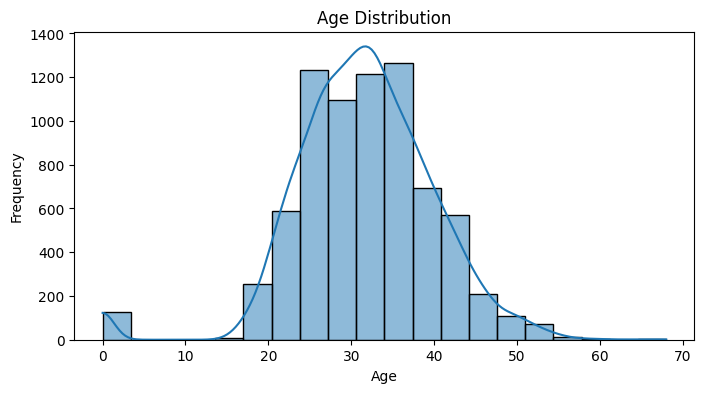

In [ ]:
# Distribution of 'age'
plt.figure(figsize=(8, 4))
sns.histplot(df['age'], kde=True, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


In [ ]:
if 'age' in df.columns:
    median_age = df['age'].median()
    # Replace 0 values with median
    df['age'] = df['age'].replace(0, median_age)



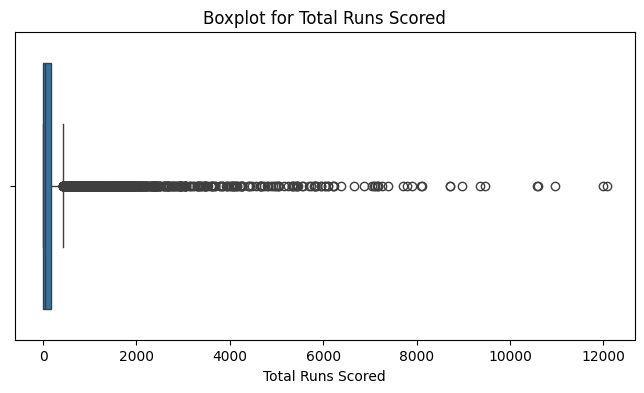

In [ ]:
# Boxplot for 'Total Runs Scored in all matches combined'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df['Total Runs Scored in all matches combined'])
plt.title('Boxplot for Total Runs Scored')
plt.xlabel('Total Runs Scored')
plt.show()

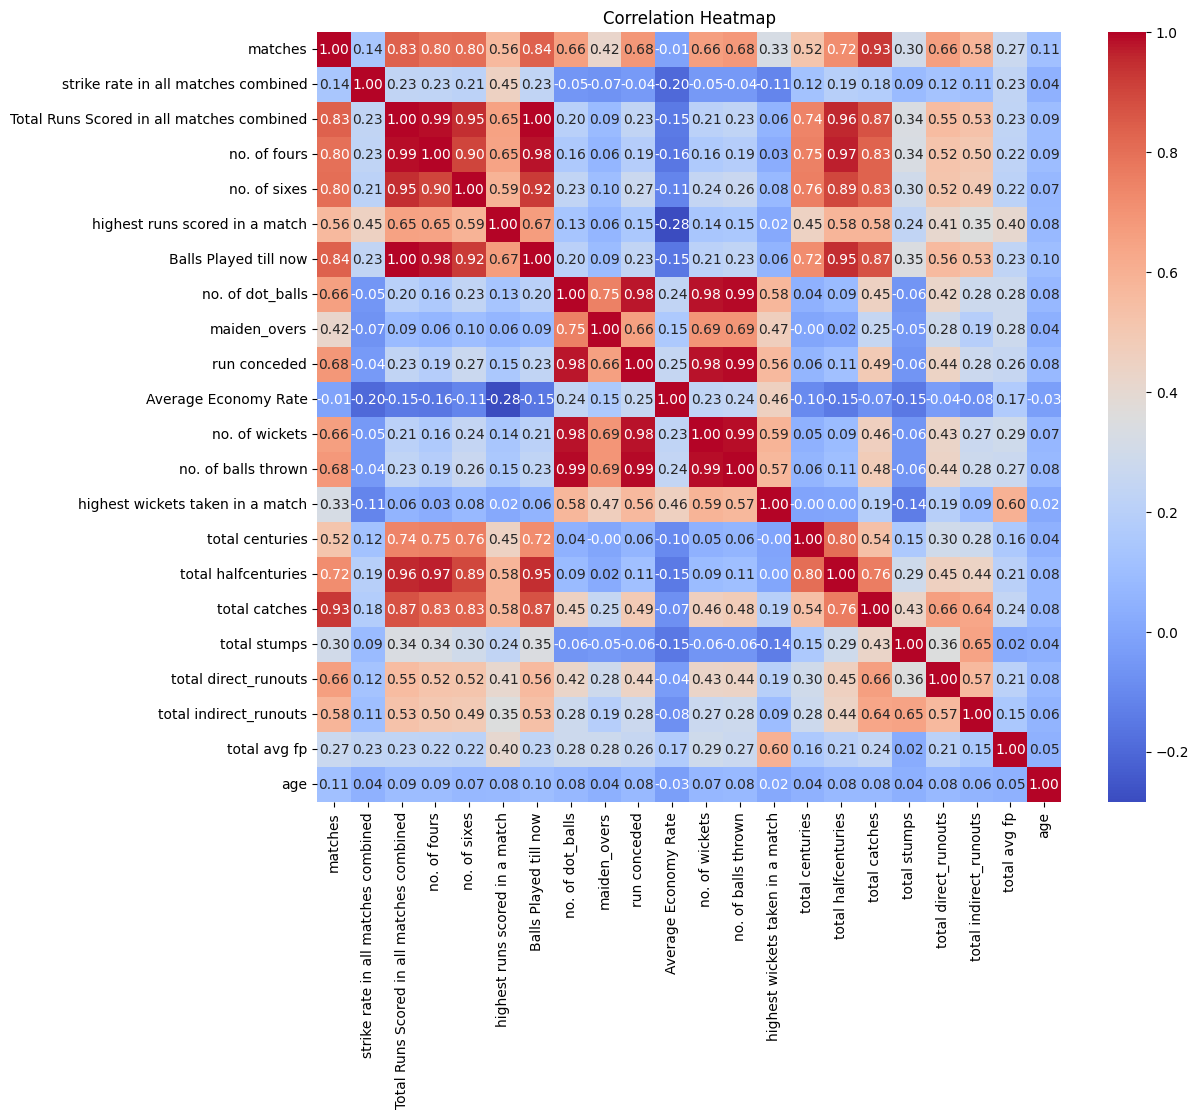

In [ ]:
# Correlation heatmap for numeric columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
# # ----- Step 7: Data Normalization/Scaling -----
# # Scale the numeric columns using StandardScaler
# scaler = StandardScaler()
# df_scaled = df.copy()
# df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])
# print("\nSample of scaled numeric features:")
# print(df_scaled[numeric_cols].head())

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numeric_cols] = scaler.fit_transform(df_scaled[numeric_cols])

print("\nSample of normalized numeric features:")
print(df_scaled[numeric_cols].head())



Sample of normalized numeric features:
    matches  strike rate in all matches combined  \
0  0.029350                             0.150265   
1  0.167715                             0.210688   
2  0.111111                             0.000000   
3  0.322851                             0.169512   
4  0.283019                             0.216442   

   Total Runs Scored in all matches combined  no. of fours  no. of sixes  \
0                                   0.021211      0.018149      0.009185   
1                                   0.060403      0.037205      0.060850   
2                                   0.087083      0.093466      0.028703   
3                                   0.385616      0.392015      0.126292   
4                                   0.298285      0.288566      0.195178   

   highest runs scored in a match  Balls Played till now  no. of dot_balls  \
0                        0.480000               0.022798          0.009620   
1                        0.302857 

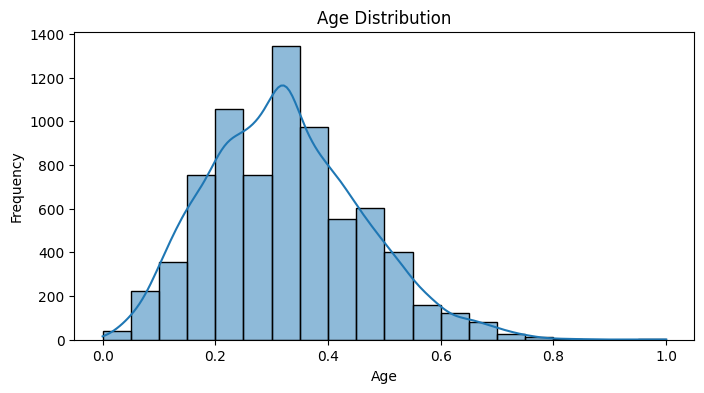

In [ ]:
# Distribution of 'age'
plt.figure(figsize=(8, 4))
sns.histplot(df_scaled['age'], kde=True, bins=20)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()


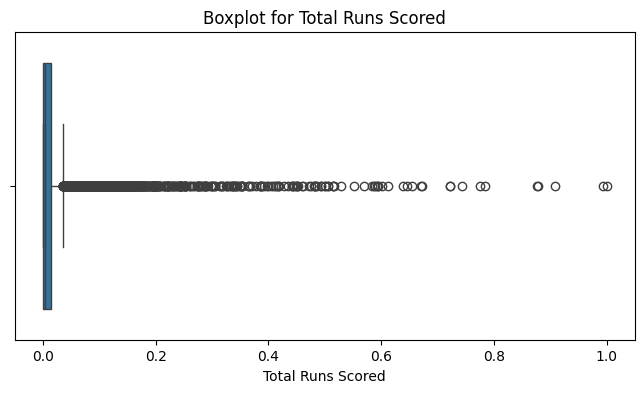

In [ ]:
# Boxplot for 'Total Runs Scored in all matches combined'
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_scaled['Total Runs Scored in all matches combined'])
plt.title('Boxplot for Total Runs Scored')
plt.xlabel('Total Runs Scored')
plt.show()

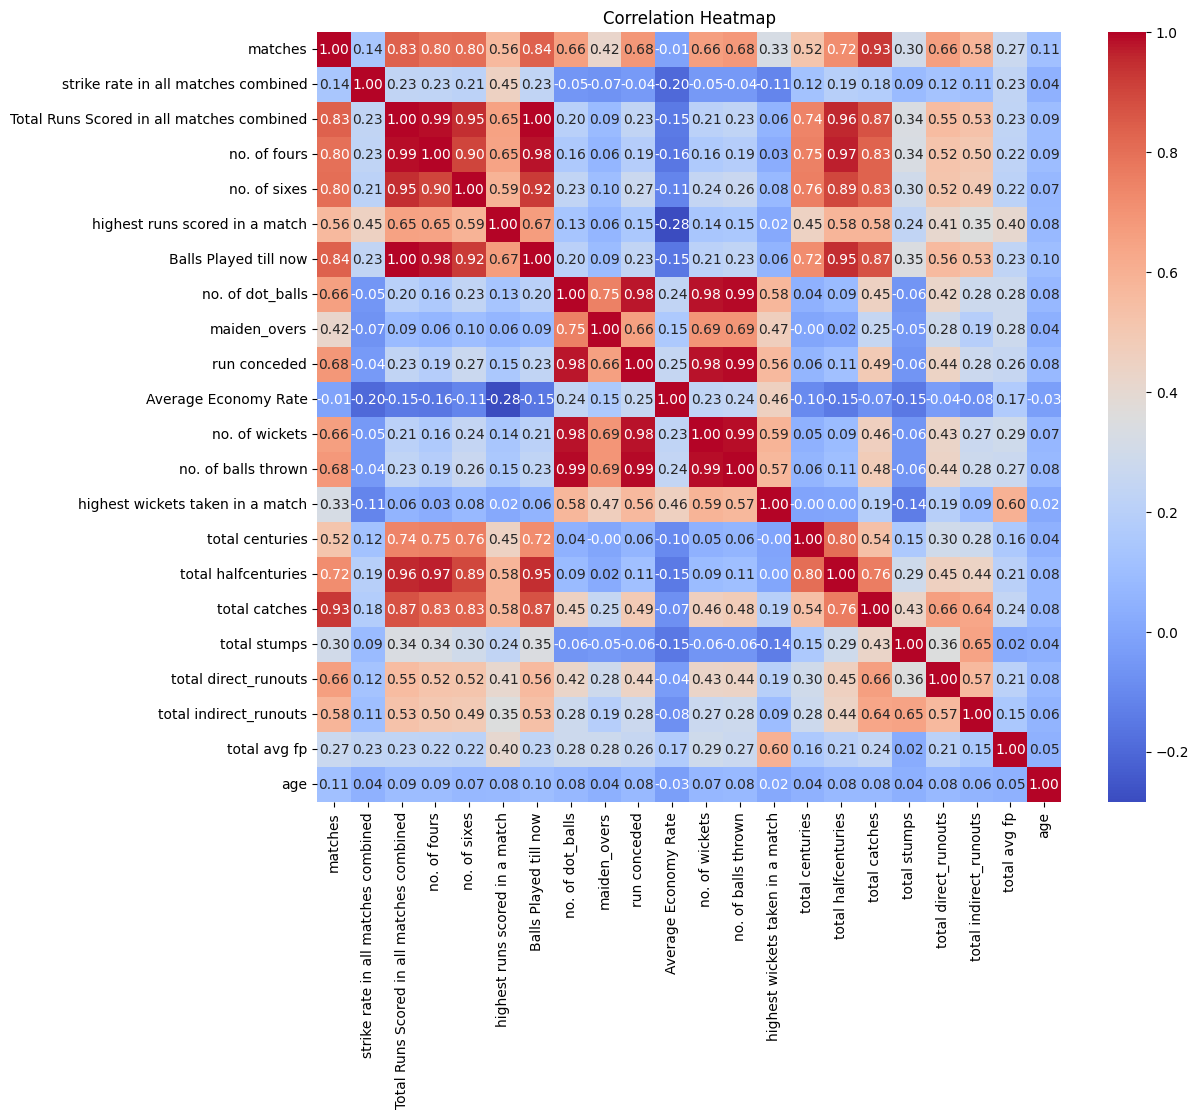

In [ ]:
# Correlation heatmap for numeric columns
plt.figure(figsize=(12, 10))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
selected_features = ['player_id', 'cricinfo_id'] + numeric_cols + ['batting', 'bowling', 'all_rounder']
df_selected = df_scaled[selected_features]
print("\nSelected features for further analysis/modeling:")
print(df_selected.head())


Selected features for further analysis/modeling:
  player_id  cricinfo_id   matches  strike rate in all matches combined  \
0  770494eb     360456.0  0.029350                             0.150265   
1  f78e7113     268740.0  0.167715                             0.210688   
2  5748e866       7252.0  0.111111                             0.000000   
3  b970a03f       6161.0  0.322851                             0.169512   
4  12b610c2     530011.0  0.283019                             0.216442   

   Total Runs Scored in all matches combined  no. of fours  no. of sixes  \
0                                   0.021211      0.018149      0.009185   
1                                   0.060403      0.037205      0.060850   
2                                   0.087083      0.093466      0.028703   
3                                   0.385616      0.392015      0.126292   
4                                   0.298285      0.288566      0.195178   

   highest runs scored in a match  Balls P

In [ ]:
df_selected.to_csv('cleaned_universal_player.csv', index=False)
print("\nCleaned data saved to 'cleaned_data.csv'")


Cleaned data saved to 'cleaned_data.csv'


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('/content/4a8a2e3b.csv')

# Display the DataFrame
print("Original DataFrame:")
print(df.head())  # Show the first few rows


Original DataFrame:
             date                  event  match_id             teamname  \
0  ['2024-05-18']  Indian Premier League   1426306  Chennai Super Kings   
1  ['2024-05-12']  Indian Premier League   1426299  Chennai Super Kings   
2  ['2024-05-10']  Indian Premier League   1426297  Chennai Super Kings   
3  ['2024-05-05']  Indian Premier League   1426291  Chennai Super Kings   
4  ['2024-05-01']  Indian Premier League   1426287  Chennai Super Kings   

   batting_position  runs  balls  fours  sixes  strike_rate  ...  \
0                 8    25     12      3      1       208.33  ...   
1                 8     0      0      0      0         0.00  ...   
2                 8    26     11      1      3       236.36  ...   
3                 9     0      1      0      0         0.00  ...   
4                 7    14     11      1      1       127.27  ...   

   economy_rate  catches  stumping  direct_hit  indirect_hit  strike_rate_fp  \
0           0.0        2         0      

In [ ]:
# Get the list of all column names
columns = df.columns.tolist()

# Print the column names
print(columns)
len(columns)

['date', 'event', 'match_id', 'teamname', 'batting_position', 'runs', 'balls', 'fours', 'sixes', 'strike_rate', 'overs_bowled', 'overs', 'total_balls', 'dots', 'maidens', 'conceded', 'fours_conceded', 'sixes_conceded', 'wickets', 'LBW', 'Bowled', 'noballs', 'wides', 'economy_rate', 'catches', 'stumping', 'direct_hit', 'indirect_hit', 'strike_rate_fp', 'batting_fp', 'bowling_fp', 'fielding_fp', 'total_fp']


33

In [ ]:
df = df.drop(columns=['date', 'event', 'teamname', 'overs_bowled'])

# Display the modified DataFrame
print("\nModified DataFrame:")
print(df.head())


Modified DataFrame:
   match_id  batting_position  runs  balls  fours  sixes  strike_rate  overs  \
0   1426306                 8    25     12      3      1       208.33    0.0   
1   1426299                 8     0      0      0      0         0.00    0.0   
2   1426297                 8    26     11      1      3       236.36    0.0   
3   1426291                 9     0      1      0      0         0.00    0.0   
4   1426287                 7    14     11      1      1       127.27    0.0   

   total_balls  dots  ...  economy_rate  catches  stumping  direct_hit  \
0            0     0  ...           0.0        2         0           0   
1            0     0  ...           0.0        0         0           0   
2            0     0  ...           0.0        0         0           0   
3            0     0  ...           0.0        1         0           0   
4            0     0  ...           0.0        1         0           0   

   indirect_hit  strike_rate_fp  batting_fp  bowling_

In [ ]:
null_counts = df.isnull().sum()

# Print the results
print("Null values in each column:")
print(null_counts)

Null values in each column:
match_id            0
batting_position    0
runs                0
balls               0
fours               0
sixes               0
strike_rate         0
overs               0
total_balls         0
dots                0
maidens             0
conceded            0
fours_conceded      0
sixes_conceded      0
wickets             0
LBW                 0
Bowled              0
noballs             0
wides               0
economy_rate        0
catches             0
stumping            0
direct_hit          0
indirect_hit        0
strike_rate_fp      0
batting_fp          0
bowling_fp          0
fielding_fp         0
total_fp            0
dtype: int64


In [ ]:
# if 'overs_bowled' in df.columns:
#     df['overs_bowled'] = df['overs_bowled'].fillna(0)

In [ ]:
df.head()

,match_id,batting_position,runs,balls,fours,sixes,strike_rate,overs,total_balls,dots,...,economy_rate,catches,stumping,direct_hit,indirect_hit,strike_rate_fp,batting_fp,bowling_fp,fielding_fp,total_fp
0,1426306,8,25,12,3,1,208.33,0.0,0,0,...,0.0,2,0,0,0,6,53,0,16,69
1,1426299,8,0,0,0,0,0.00,0.0,0,0,...,0.0,0,0,0,0,0,0,0,0,0
2,1426297,8,26,11,1,3,236.36,0.0,0,0,...,0.0,0,0,0,0,6,58,0,0,58
3,1426291,9,0,1,0,0,0.00,0.0,0,0,...,0.0,1,0,0,0,0,-2,0,8,6
4,1426287,7,14,11,1,1,127.27,0.0,0,0,...,0.0,1,0,0,0,0,24,0,8,32


In [ ]:
# ----- Step 3: Data Type Conversion -----
# Define numeric columns (adjust as needed)
numeric_cols = [ 'batting_position', 'runs','balls', 'fours', 'sixes', 'strike_rate',
                'overs', 'total_balls', 'dots', 'maidens',
                'conceded', 'fours_conceded', 'sixes_conceded',
                'wickets', 'LBW', 'Bowled', 'noballs',
                'wides', 'economy_rate', 'catches', 'stumping', 'direct_hit', 'indirect_hit']

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')
len(numeric_cols)

23

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Normalize the numeric columns
scaler = MinMaxScaler()
df_normalized = df.copy()
df_normalized[numeric_cols] = scaler.fit_transform(df[numeric_cols])

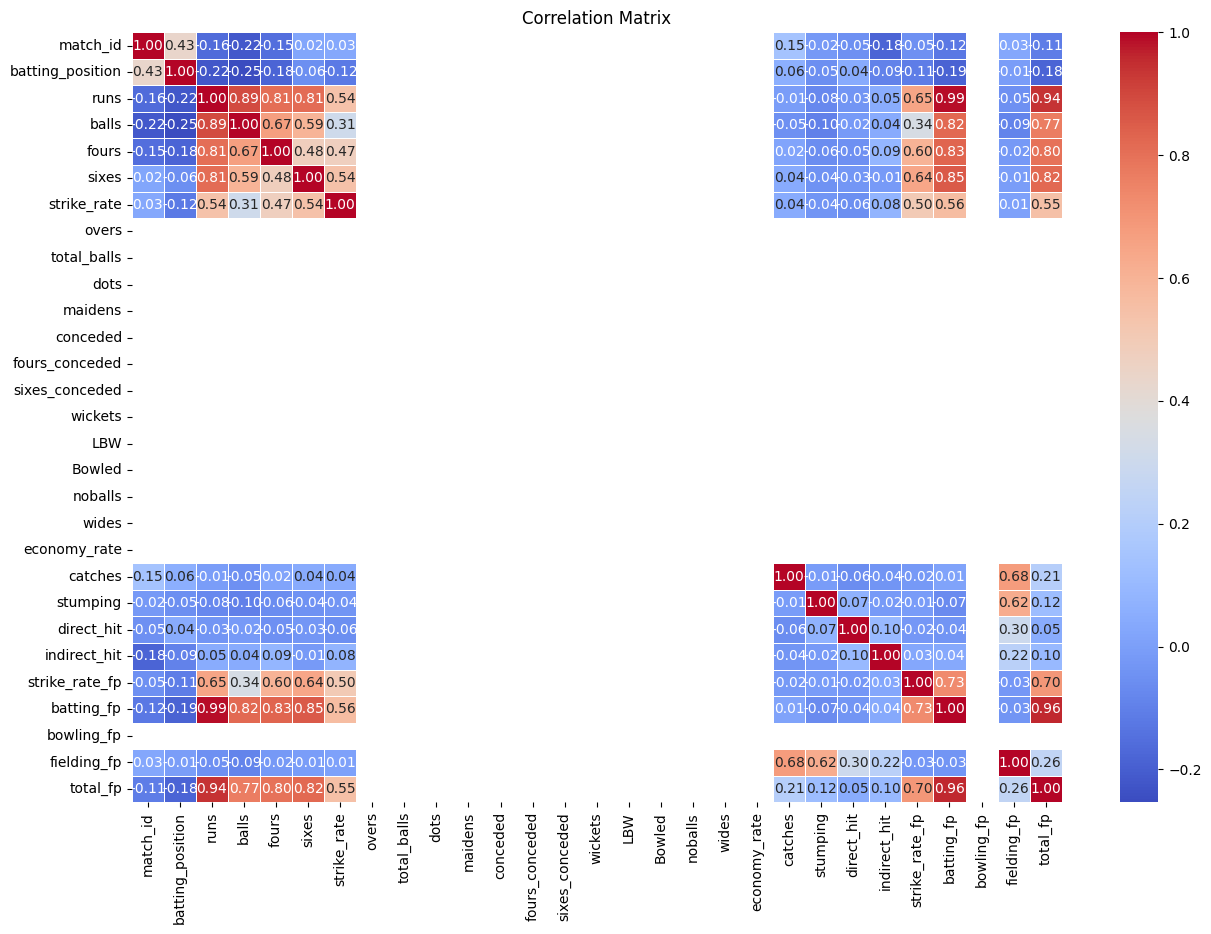

In [ ]:
# Correlation Matrix
plt.figure(figsize=(15, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [ ]:


selected_features = ['match_id'] + numeric_cols + ['strike_rate_fp', 'batting_fp', 'bowling_fp', 'fielding_fp', 'total_fp']
df_selected = df_normalized[selected_features]
print("\nSelected features for further analysis/modeling:")
df_selected.head()


Selected features for further analysis/modeling:


,match_id,batting_position,runs,balls,fours,sixes,strike_rate,overs,total_balls,dots,...,economy_rate,catches,stumping,direct_hit,indirect_hit,strike_rate_fp,batting_fp,bowling_fp,fielding_fp,total_fp
0,1426306,0.833333,0.297619,0.255319,0.333333,0.142857,0.41666,0.0,0.0,0.0,...,0.0,0.4,0.0,0.0,0.0,6,53,0,16,69
1,1426299,0.833333,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0
2,1426297,0.833333,0.309524,0.234043,0.111111,0.428571,0.47272,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,6,58,0,0,58
3,1426291,1.000000,0.000000,0.021277,0.000000,0.000000,0.00000,0.0,0.0,0.0,...,0.0,0.2,0.0,0.0,0.0,0,-2,0,8,6
4,1426287,0.666667,0.166667,0.234043,0.111111,0.142857,0.25454,0.0,0.0,0.0,...,0.0,0.2,0.0,0.0,0.0,0,24,0,8,32


In [ ]:
df_selected.to_csv('cleaned_4a8a2e3b.csv', index=False)
print("\nCleaned data saved to 'cleaned_data.csv'")


Cleaned data saved to 'cleaned_data.csv'


In [ ]:
## WEATHER FECTHING

In [ ]:
!pip install openmeteo_requests
!pip install retry-requests
!pip install requests_cache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 4.6 MB/s eta 0:00:00


In [ ]:
import openmeteo_requests
import requests_cache
import pandas as pd
from retry_requests import retry
import time
from tqdm import tqdm  # Import tqdm for progress bar

In [ ]:
# Load match data
matches_df = pd.read_csv("/content/updated_matches_info1.csv")

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after=-1)
retry_session = retry(cache_session, retries=5, backoff_factor=0.2)
openmeteo = openmeteo_requests.Client(session=retry_session)

# Weather API URL
url = "https://archive-api.open-meteo.com/v1/archive"

# List to store weather data
weather_data = []

# Use tqdm to show progress over the DataFrame rows
for index, row in tqdm(matches_df.iterrows(), total=matches_df.shape[0], desc="Processing matches"):
    match_id = row["match_id"]
    latitude = row["venue_lat"]
    longitude = row["venue_long"]
    match_date = row["match_date"]

    # Skip rows with missing lat/lon
    if pd.isna(latitude) or pd.isna(longitude):
        continue

    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": match_date,
        "end_date": match_date,
        "daily": "apparent_temperature_mean",
        "hourly": ["relative_humidity_2m", "apparent_temperature", "precipitation", "is_day",
                   "temperature_2m_spread", "temperature_2m"]
    }

    try:
        responses = openmeteo.weather_api(url, params=params)
        response = responses[0]

        # Process daily data
        daily = response.Daily()
        daily_apparent_temperature_mean = daily.Variables(0).ValuesAsNumpy()[0]

        # Process hourly data
        hourly = response.Hourly()
        hourly_relative_humidity_2m = hourly.Variables(0).ValuesAsNumpy().mean()
        hourly_apparent_temperature = hourly.Variables(1).ValuesAsNumpy().mean()
        hourly_precipitation = hourly.Variables(2).ValuesAsNumpy().sum()
        hourly_is_day = hourly.Variables(3).ValuesAsNumpy().mean()
        hourly_temperature_2m_spread = hourly.Variables(4).ValuesAsNumpy().mean()
        hourly_temperature_2m = hourly.Variables(5).ValuesAsNumpy().mean()

        weather_data.append([
            match_id, match_date, latitude, longitude, daily_apparent_temperature_mean,
            hourly_relative_humidity_2m, hourly_apparent_temperature,
            hourly_precipitation, hourly_is_day, hourly_temperature_2m_spread,
            hourly_temperature_2m
        ])

        # Delay to avoid hitting API limits
        time.sleep(1)
    except Exception as e:
        print(f"Error fetching data for match {match_id}: {e}")

# Convert to DataFrame and save
weather_df = pd.DataFrame(weather_data, columns=[
    "match_id", "match_date", "latitude", "longitude", "daily_apparent_temperature_mean",
    "hourly_relative_humidity_2m", "hourly_apparent_temperature",
    "hourly_precipitation", "hourly_is_day", "hourly_temperature_2m_spread",
    "hourly_temperature_2m"
])

weather_df.to_csv("weather.csv", index=False)
print("Weather data saved to weather.csv")

Processing matches:  93%|█████████▎| 7055/7620 [1:56:09<07:02,  1.34it/s]

Error fetching data for match 1456013: {'reason': "Invalid date format. Make sure to use 'YYYY-MM-DD'", 'error': True}


Processing matches: 100%|██████████| 7620/7620 [2:05:00<00:00,  1.02it/s]

Weather data saved to weather.csv


In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('cleaned_universal_player.csv')

# Display the DataFrame
print("Original DataFrame:")
df.head()  # Show the first few rows


Original DataFrame:


,player_id,cricinfo_id,matches,strike rate in all matches combined,Total Runs Scored in all matches combined,no. of fours,no. of sixes,highest runs scored in a match,Balls Played till now,no. of dot_balls,...,total halfcenturies,total catches,total stumps,total direct_runouts,total indirect_runouts,total avg fp,age,batting,bowling,all_rounder
0,770494eb,360456.0,0.029350,0.150265,0.021211,0.018149,0.009185,0.480000,0.022798,0.009620,...,0.019231,0.027778,0.000000,0.055556,0.00,0.241469,0.452830,True,False,False
1,f78e7113,268740.0,0.167715,0.210688,0.060403,0.037205,0.060850,0.302857,0.057331,0.105131,...,0.019231,0.095238,0.000000,0.055556,0.00,0.226718,0.452830,False,False,True
2,5748e866,7252.0,0.111111,0.000000,0.087083,0.093466,0.028703,0.520000,0.098458,0.000000,...,0.067308,0.154762,0.131579,0.055556,0.08,0.223555,0.471698,True,False,False
3,b970a03f,6161.0,0.322851,0.169512,0.385616,0.392015,0.126292,0.720000,0.423782,0.000000,...,0.298077,0.261905,0.000000,0.166667,0.00,0.281598,0.547170,True,False,False
4,12b610c2,530011.0,0.283019,0.216442,0.298285,0.288566,0.195178,0.582857,0.273357,0.029776,...,0.192308,0.150794,0.000000,0.000000,0.02,0.292416,0.301887,True,False,False


In [ ]:
df[['batting', 'bowling', 'all_rounder']] = df[['batting', 'bowling', 'all_rounder']].astype(int)

df.head()

,player_id,cricinfo_id,matches,strike rate in all matches combined,Total Runs Scored in all matches combined,no. of fours,no. of sixes,highest runs scored in a match,Balls Played till now,no. of dot_balls,...,total halfcenturies,total catches,total stumps,total direct_runouts,total indirect_runouts,total avg fp,age,batting,bowling,all_rounder
0,770494eb,360456.0,0.029350,0.150265,0.021211,0.018149,0.009185,0.480000,0.022798,0.009620,...,0.019231,0.027778,0.000000,0.055556,0.00,0.241469,0.452830,1,0,0
1,f78e7113,268740.0,0.167715,0.210688,0.060403,0.037205,0.060850,0.302857,0.057331,0.105131,...,0.019231,0.095238,0.000000,0.055556,0.00,0.226718,0.452830,0,0,1
2,5748e866,7252.0,0.111111,0.000000,0.087083,0.093466,0.028703,0.520000,0.098458,0.000000,...,0.067308,0.154762,0.131579,0.055556,0.08,0.223555,0.471698,1,0,0
3,b970a03f,6161.0,0.322851,0.169512,0.385616,0.392015,0.126292,0.720000,0.423782,0.000000,...,0.298077,0.261905,0.000000,0.166667,0.00,0.281598,0.547170,1,0,0
4,12b610c2,530011.0,0.283019,0.216442,0.298285,0.288566,0.195178,0.582857,0.273357,0.029776,...,0.192308,0.150794,0.000000,0.000000,0.02,0.292416,0.301887,1,0,0


#### Data Consolidation

In [ ]:
## Concatation of the Input Embedding

#### Generated Training Sequences

#### Create the DataLoader

In [ ]:
# import os
# import numpy as np
# import pandas as pd
# from torch.utils.data import Dataset

# class PlayerMatchDataset(Dataset):
#     """
#     Dataset for autoregressive next-match prediction.

#     For each sample:
#       1. Given a player_id, retrieve universal player features from universal_player.csv.
#          (We drop the 'player_id' and 'cricinfo_id' from the input features.)
#       2. Retrieve all matches for that player from player_matches.csv (sorted by date).
#          The performance columns include:
#            batting_position, runs, balls, fours, sixes, strike_rate, overs, total_balls, dots,
#            maidens, conceded, fours_conceded, sixes_conceded, wickets, LBW, Bowled, noballs,
#            wides, economy_rate, catches, stumping, direct_hit, indirect_hit, strike_rate_fp,
#            batting_fp, bowling_fp, fielding_fp, total_fp.
#          We drop 'match_id' and the fantasy-breakdown columns
#          ('strike_rate_fp', 'batting_fp', 'bowling_fp', 'fielding_fp', 'total_fp') when forming the input vector.
#       3. Randomly sample a contiguous window of (context_len + 1) matches from this player.
#          The first context_len matches serve as input and matches 2...context_len+1 yield the target fantasy scores.
#       4. For each match in the window:
#          - Load the corresponding match_players CSV from the match_players folder (file: '{match_id}.csv').
#          - Separate the player_ids into team1 and team2 (based on the 'Team' column).
#          - Retrieve their universal features from universal_player.csv.
#          - Load the match info from the match_info folder (file: '{match_id}_info.csv').
#       5. Return a dictionary containing:
#          - 'univ_features': the player's universal features.
#          - 'context_matches': an array of performance features for the context matches.
#          - 'target_scores': an array of target fantasy scores.
#          - 'team1_players': list of team1 players' universal features for each match.
#          - 'team2_players': list of team2 players' universal features for each match.
#          - 'match_info': list of match info dictionaries for each match.
#     """

#     def __init__(self, universal_player_csv, player_matches_csv, match_players_dir, match_info_dir, context_len=5, transform=None):
#         """
#         Args:
#             universal_player_csv (str): Path to universal_player.csv.
#             player_matches_csv (str): Path to player_matches.csv.
#             match_players_dir (str): Directory containing match_players CSV files.
#             match_info_dir (str): Directory containing match info CSV files.
#             context_len (int): Number of context matches to use as input (the target will be matches 2 ... context_len+1).
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.context_len = context_len
#         self.transform = transform

#         # Load universal player features and set player_id as index.
#         self.univ_df = pd.read_csv(universal_player_csv)
#         self.univ_df = self.univ_df.set_index('player_id')
#         # Drop cricinfo_id since it is redundant.
#         self.univ_features = self.univ_df.drop(columns=['cricinfo_id'], errors='ignore')

#         # Load player matches and sort by date.
#         self.matches_df = pd.read_csv(player_matches_csv)
#         self.matches_df['date'] = pd.to_datetime(self.matches_df['date'])
#         self.matches_df = self.matches_df.sort_values(by='date')

#         # Build an index: for each player_id, list the row indices in matches_df.
#         self.player_match_indices = {}
#         for player_id, group in self.matches_df.groupby('player_id'):
#             indices = group.index.tolist()
#             # Only include players with at least (context_len + 1) matches.
#             if len(indices) >= (self.context_len + 1):
#                 self.player_match_indices[player_id] = indices

#         self.match_players_dir = match_players_dir
#         self.match_info_dir = match_info_dir

#         # Valid player_ids (those with enough matches)
#         self.player_ids = list(self.player_match_indices.keys())

#     def __len__(self):
#         return len(self.player_ids)

#     def __getitem__(self, idx):
#         """
#         Returns a dictionary with:
#         - 'player_id': the player's id.
#         - 'univ_features': universal features for the player.
#         - 'context_matches': performance features for the first context_len matches.
#         - 'target_scores': fantasy scores from matches 2 to context_len+1.
#         - 'team1_players': for each match, universal features for team1 players.
#         - 'team2_players': for each match, universal features for team2 players.
#         - 'match_info': match-specific info for each match.
#         """
#         # Select the player
#         player_id = self.player_ids[idx]
#         # Get the player's universal features (as a numpy array of floats)
#         player_univ = self.univ_features.loc[player_id].values.astype(float)
#         print(player_univ)
        
#         # Get indices for all matches of this player.
#         match_indices = self.player_match_indices[player_id]
#         # Randomly select a contiguous window of (context_len + 1) matches.
#         start_idx = np.random.randint(0, len(match_indices) - self.context_len)
#         selected_indices = match_indices[start_idx : start_idx + self.context_len + 1]
#         selected_matches = self.matches_df.loc[selected_indices]

#         # For input, we drop the columns that are not used: 'match_id' and fantasy-breakdown columns.
#         exclude_cols = ['teamname', 'match_id', 'strike_rate_fp', 'batting_fp', 'bowling_fp', 'fielding_fp', 'total_fp']
#         # Target fantasy scores (assumed to be in column 'total_fp') from matches 2 ... context_len+1.
#         target_scores = selected_matches.iloc[1:self.context_len+1]['total_fp'].values.astype(float)
#         context_matches = selected_matches.iloc[:self.context_len].drop(columns=exclude_cols, errors='ignore')

#         # For each match in the window, retrieve team player ids and match info.
#         team1_players_list = [] 
#         team2_players_list = []
#         match_info_list = []
#         for _, match in selected_matches.iterrows():
#             match_id = match['match_id']
#             # Load match players file (expects a file named "{match_id}.csv")
#             match_players_file = os.path.join(self.match_players_dir, f"{match_id}.csv")
#             match_players_df = pd.read_csv(match_players_file)
            
#             # Determine the player's team for this match.
#             player_team_series = match_players_df[match_players_df['player_id'] == player_id]['Team']
#             if not player_team_series.empty:
#                 player_team = player_team_series.iloc[0]
#             else:
#                 # If player's team is not found, default to first team (or handle as needed).
#                 player_team = match_players_df.iloc[0]['Team']
            
#             # Use the player's team name to split the teams.
#             team1_ids = match_players_df[match_players_df['Team'] == player_team]['player_id'].tolist()
#             team2_ids = match_players_df[match_players_df['Team'] != player_team]['player_id'].tolist()

#             # Retrieve universal features for these players.
#             team1_features = self.univ_features.reindex(team1_ids).dropna().values.astype(float)
#             team2_features = self.univ_features.reindex(team2_ids).dropna().values.astype(float)

#             team1_players_list.append(team1_features)
#             print(team1_players_list.size())
#             team2_players_list.append(team2_features)
#             print(len(team2_players_list))
            
#             # Load match info file (expects a file named "{match_id}_info.csv")
#             match_info_file = os.path.join(self.match_info_dir, f"{match_id}_info.csv")
#             match_info_df = pd.read_csv(match_info_file)
#             match_info_list.append(match_info_df.to_dict(orient='list'))
#             print(len(match_info_list))

#         sample = {
#             'player_id': player_id,
#             'univ_features': player_univ,                         # Universal features for the player.
#             'context_matches': context_matches.values.astype(float),  # Performance features for context matches.
#             'target_scores': target_scores,                       # Target fantasy scores.
#             'team1_players': team1_players_list,                  # List (per match) of team1 players' universal features.
#             'team2_players': team2_players_list,                  # List (per match) of team2 players' universal features.
#             'match_info': match_info_list                         # List (per match) of match info dictionaries.
#         }

#         if self.transform:
#             sample = self.transform(sample)
#         return sample


In [ ]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset

class PlayerMatchDataset(Dataset):
    """
    Dataset for autoregressive next-match prediction.

    For each sample:
      1. Given a player_id, retrieve universal player features from universal_player.csv.
         (The 'player_id' and 'cricinfo_id' columns are dropped from the input features.)
      2. Retrieve all matches for that player from a directory of player match files
         (each file is named "{player_id}.csv" and contains the matches for that player,
         already sorted by date).
         The performance columns include:
           batting_position, runs, balls, fours, sixes, strike_rate, overs, total_balls, dots,
           maidens, conceded, fours_conceded, sixes_conceded, wickets, LBW, Bowled, noballs,
           wides, economy_rate, catches, stumping, direct_hit, indirect_hit, strike_rate_fp,
           batting_fp, bowling_fp, fielding_fp, total_fp.
         We drop 'match_id' and the fantasy-breakdown columns
         ('strike_rate_fp', 'batting_fp', 'bowling_fp', 'fielding_fp', 'total_fp') when forming the input vector.
      3. Randomly sample a contiguous window of (context_len + 1) matches for this player.
         The first context_len matches serve as input and matches 2 ... context_len+1 yield the target fantasy scores.
      4. For each match in the window:
         - Load the corresponding match players CSV from the match_players folder (file: '{match_id}.csv').
         - Determine the player's team for that match and then separate player_ids into:
              team1_ids: those belonging to the same team as the player,
              team2_ids: those belonging to the other team.
         - Retrieve their universal features from universal_player.csv.
         - Retrieve match info from a single match_info CSV (by matching on match_id).
      5. Return a dictionary containing:
         - 'player_id': the player's id.
         - 'univ_features': the player's universal features.
         - 'context_matches': a numpy array of performance features for the context matches.
         - 'target_scores': a numpy array of target fantasy scores (for matches 2 ... context_len+1).
         - 'team1_players': list (per match) of team1 players' universal features.
         - 'team2_players': list (per match) of team2 players' universal features.
         - 'match_info': list (per match) of match info dictionaries.
    """

    def __init__(self, universal_player_csv, player_matches_dir, match_players_dir, match_info_csv, context_len=25, transform=None):
        """
        Args:
            universal_player_csv (str): Path to universal_player.csv.
            player_matches_dir (str): Directory containing CSV files for each player's matches (named '{player_id}.csv').
            match_players_dir (str): Directory containing match_players CSV files.
            match_info_csv (str): Path to the CSV file containing match info for all matches.
            context_len (int): Number of context matches to use as input 
                                (target will be matches 2 ... context_len+1).
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.context_len = context_len
        self.transform = transform

        # Load universal player features and set player_id as index.
        self.univ_df = pd.read_csv(universal_player_csv)
        self.univ_df = self.univ_df.set_index('player_id')
        # Drop 'cricinfo_id' as it is redundant.
        self.univ_features = self.univ_df.drop(columns=['cricinfo_id'], errors='ignore')

        # Instead of a single file for player matches, we assume a directory where each player's
        # matches are stored in a file named '{player_id}.csv'. We build a list of valid player_ids
        # by checking which player match files exist and ensuring they have at least (context_len+1) rows.
        self.player_matches_dir = player_matches_dir
        self.player_ids = []
        self.player_match_data = {}  # Key: player_id, Value: DataFrame of that player's matches.
        for player_id in self.univ_features.index:
            match_file = os.path.join(player_matches_dir, f"{player_id}.csv")
            if os.path.exists(match_file):
                df_matches = pd.read_csv(match_file)
                # Assume the matches in this file are already sorted by date.
                if len(df_matches) >= (self.context_len + 1):
                    self.player_ids.append(player_id)
                    self.player_match_data[player_id] = df_matches

        self.match_players_dir = match_players_dir

        # Load the single match_info CSV and set match_id as index for fast lookup.
        self.match_info_df = pd.read_csv(match_info_csv)
        self.match_info_df = self.match_info_df.set_index('match_id')
        # Optionally drop columns not needed.
        self.match_info_df = self.match_info_df.drop(columns=['team1', 'team2', 'toss_winner', "toss_decision", "winner"], errors='ignore')

    def __len__(self):
        return len(self.player_ids)

    def __getitem__(self, idx):
        """
        Returns a dictionary with:
          - 'player_id': the player's id.
          - 'univ_features': universal features for the player.
          - 'context_matches': a numpy array of performance features for the first context_len matches.
          - 'target_scores': a numpy array of target fantasy scores (for matches 2 ... context_len+1).
          - 'team1_players': list (per match) of team1 players' universal features.
          - 'team2_players': list (per match) of team2 players' universal features.
          - 'match_info': list (per match) of match info dictionaries.
        """
        # Select the player.
        player_id = self.player_ids[idx]
        # Retrieve the player's universal features as a numpy array.
        player_univ = self.univ_features.loc[player_id].values.astype(float)
        # Load this player's matches DataFrame from the pre-loaded dictionary.
        df_matches = self.player_match_data[player_id]
        total_matches = len(df_matches)
        # Randomly select a contiguous window of (context_len + 1) matches.
        start_idx = np.random.randint(0, total_matches - self.context_len)
        window_df = df_matches.iloc[start_idx : start_idx + self.context_len + 1]

        # For input, drop the unused columns.
        exclude_cols = ['teamname', 'match_id', 'strike_rate_fp', 'batting_fp', 'bowling_fp', 'fielding_fp', 'total_fp']
        # Extract target fantasy scores (from column 'total_fp') for matches 2 ... context_len+1.
        target_scores = window_df.iloc[1:self.context_len+1]['total_fp'].values.astype(float)
        # Extract performance features for input matches.
        context_matches = window_df.iloc[:self.context_len].drop(columns=exclude_cols, errors='ignore')

        # For each match in the window, retrieve team players and match info.
        team1_players_list = [] 
        team2_players_list = []
        match_info_list = []
        for _, match in window_df.iterrows():
            match_id = match['match_id']
            # Load match players file (expects a file named "{match_id}.csv").
            match_players_file = os.path.join(self.match_players_dir, f"{match_id}.csv")
            match_players_df = pd.read_csv(match_players_file)
            
            # Determine the team of the sample's player in this match.
            player_team_series = match_players_df[match_players_df['player_id'] == player_id]['Team']
            if not player_team_series.empty:
                player_team = player_team_series.iloc[0]
            else:
                player_team = match_players_df.iloc[0]['Team']
            
            # Split player_ids into two groups based on the player's team.
            team1_ids = match_players_df[match_players_df['Team'] == player_team]['player_id'].tolist()
            team2_ids = match_players_df[match_players_df['Team'] != player_team]['player_id'].tolist()

            # Retrieve universal features for these players.
            team1_features = self.univ_features.reindex(team1_ids).dropna().values.astype(float)
            team2_features = self.univ_features.reindex(team2_ids).dropna().values.astype(float)
            team1_players_list.append(team1_features)
            team2_players_list.append(team2_features)
            
            # Retrieve match info using match_id from the single match_info DataFrame.
            if match_id in self.match_info_df.index:
                match_info_dict = self.match_info_df.loc[match_id].to_dict()
            else:
                match_info_dict = {}
            match_info_list.append(match_info_dict)

        sample = {
            'player_id': player_id,
            'univ_features': player_univ,                          # Universal features for the player.
            'context_matches': context_matches.values.astype(float),  # Performance features for input matches.
            'target_scores': target_scores,                        # Fantasy scores for target matches.
            'team1_players': team1_players_list,                   # List (per match) of team1 players' universal features.
            'team2_players': team2_players_list,                   # List (per match) of team2 players' universal features.
            'match_info': match_info_list                          # List (per match) of match info dictionaries.
        }
        
        if self.transform:
            sample = self.transform(sample)
        return sample


In [ ]:
import os
from torch.utils.data import DataLoader

# Define file paths (update these paths as needed for your folder structure)
universal_player_csv = r'c:\Users\umbar\OneDrive\Documents\Fantasy Point Prediction\IPL_Fantasy_Score_Prediction\Ashu\Test_1\cleaned_universal_player.csv'
player_matches_dir = r'c:\Users\umbar\OneDrive\Documents\Fantasy Point Prediction\IPL_Fantasy_Score_Prediction\Ashu\Test_1\Cleaned_Global_player_csvs'  # Contains files named like {player_id}.csv (each containing that player's matches)
match_players_dir = r'c:\Users\umbar\OneDrive\Documents\Fantasy Point Prediction\IPL_Fantasy_Score_Prediction\Ashu/Test_1/processed_GlobalMatchrecords'    # Contains files like {match_id}.csv
match_info_csv = r'c:\Users\umbar\OneDrive\Documents\Fantasy Point Prediction\IPL_Fantasy_Score_Prediction\Ashu/Test_1/cleaned_matchinfo_without_venue.csv'               # Single CSV containing all match info

# Define the context length (number of matches to use as context)
# For example, if config.CONTEXT_LEN is defined in your config module:
# config.CONTEXT_LEN = 5

# Initialize the dataset
dataset = PlayerMatchDataset(
    universal_player_csv=universal_player_csv,
    player_matches_dir=player_matches_dir,  # This parameter may be ignored if you use the directory version
    match_players_dir=match_players_dir,
    match_info_csv=match_info_csv,
    context_len=config.CONTEXT_LEN
)

def get_shape(lst):
    shape = []
    while isinstance(lst, list):
        shape.append(len(lst))
        if len(lst) == 0:
            break
        lst = lst[0]
    return tuple(shape)



# Initialize the DataLoader
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=0)

# Iterate through one batch to check the output shapes and values
for batch in dataloader:
    print("Player IDs:", batch['player_id'])  # list of player_ids (length = batch_size)
    
    print("Universal features shape:", (batch['univ_features']))  # e.g., (batch_size, num_features)
    
    print("Context matches shape:", batch['context_matches'].shape)  # e.g., (batch_size, context_len, performance_feature_dim)
    
    print("Target scores shape:", batch['target_scores'].shape)      # e.g., (batch_size, context_len)
    
    # The following are lists of length (context_len+1); each element is a numpy array.
    team1_players_tensor = list_of_tensors_to_3d(batch['team1_players'])
    team1_players_tensor = team1_players_tensor.squeeze(2)
    print("Number of matches in team1_players (per sample):", team1_players_tensor.shape)
    
    team2_players_tensor = list_of_tensors_to_3d(batch['team2_players'])
    team2_players_tensor = team2_players_tensor.squeeze(2)
    print("Number of matches in team2_players (per sample):", team2_players_tensor.shape)
    
    match_info_tensor = list_of_dicts_to_tensor(batch['match_info'])
    print("Number of matches in match_info (per sample):", (match_info_tensor).shape)
    break

# 82e81007

Player IDs: ['2f49c897']
Universal features shape: tensor([[0.2767, 0.0000, 0.0115, 0.0118, 0.0046, 0.0800, 0.0179, 0.2820, 0.2500,
         0.3116, 0.1595, 0.2751, 0.2857, 0.5714, 0.0000, 0.0000, 0.1627, 0.0000,
         0.2222, 0.0800, 0.2435, 0.3019, 0.0000, 1.0000, 0.0000]],
       dtype=torch.float64)
Context matches shape: torch.Size([1, 16, 23])
Target scores shape: torch.Size([1, 16])
Number of matches in team1_players (per sample): torch.Size([1, 17, 11, 25])
Number of matches in team2_players (per sample): torch.Size([1, 17, 11, 25])
Number of matches in match_info (per sample): torch.Size([1, 17, 13])


In [7]:
def list_of_tensors_to_3d(tensor_list):
    """
    Converts a list of tensors into a 3D tensor with shape:
    (1, number_of_tensors, *inner_tensor_shape)
    
    Args:
        tensor_list (list of torch.Tensor): List of tensors with identical shapes.
        
    Returns:
        torch.Tensor: A tensor with the new shape (1, len(tensor_list), inner dims...).
    """
    # First stack the tensors along dimension 0: shape becomes (number_of_tensors, inner dims...)
    stacked = torch.stack(tensor_list, dim=0)
    # Add a leading dimension to obtain the final shape (1, number_of_tensors, inner dims...)
    return stacked.unsqueeze(0)


def list_of_dicts_to_tensor(data, key_order=None):
    """
    Convert a list of dictionaries (each with tensor or numeric values) 
    into a 3D tensor of shape (1, number_of_dicts, number_of_keys).

    Args:
        data (list): List of dictionaries where each dictionary contains the same keys.
        key_order (list, optional): Specific order of keys to extract from each dictionary.
                                    If None, keys from the first dictionary are used.

    Returns:
        torch.Tensor: A 3D tensor with shape (1, len(data), len(key_order)).
    """
    if not data:
        raise ValueError("The input data list is empty.")
    
    # Use keys from the first dictionary if no order is specified.
    if key_order is None:
        key_order = list(data[0].keys())
    
    values_list = []
    for d in data:
        # Extract values in the specified order. Convert tensor values to scalar if necessary.
        values = []
        for key in key_order:
            value = d[key]
            if isinstance(value, torch.Tensor):
                # Assuming tensor is of shape (1,)
                values.append(value.item())
            else:
                values.append(value)
        values_list.append(values)
    
    # Convert the list of lists to a 2D tensor.
    tensor_2d = torch.tensor(values_list)
    # Add a new dimension at the beginning to make it 3D.
    tensor_3d = tensor_2d.unsqueeze(0)
    return tensor_3d

In [18]:
import os
print("Current working directory:", os.getcwd())


Current working directory: c:\Users\umbar\OneDrive\Documents\Fantasy Point Prediction\IPL_Fantasy_Score_Prediction\Ashu


## Model Architecture

In [ ]:
class PlayerEmbedding(nn.Module):
  """ HEre we are doing the Proj of the raw Player embedding into the PERFORMANCE_EMBD_DIM """
  def __init__(self, in_channels=config.PLAYER_INPUT_DIM, out_channels=config.PERFORMANCE_EMBD_DIM):
    super().__init__()
    self.proj = nn.Linear(in_channels, out_channels)

  def forward(self, x):
    # x: (B, PLAYER_INPUT_DIM) or flattened (B*T, PLAYER_INPUT_DIM)
    return self.proj(x)   ## ( B/B*T, PERFORMANCE_EMBD)

In [ ]:
class MatchEmbedding(nn.Module):
    """
    Computes a match-level embedding from team and match information.
    Expected input shapes (for T matches):
      team1_players: (B, T, num_team1, PLAYER_INPUT_DIM)
      team2_players: (B, T, num_team2, PLAYER_INPUT_DIM)
      match_info: (B, T, match_info_dim)
    Output:
      (B, T, PERFORMANCE_EMBD_DIM)
    """
    def __init__(self, player_embedding_module, in_channels=(2*config.PERFORMANCE_EMBD_DIM + config.MATCH_INPUT_EMBD), out_channels=config.PERFORMANCE_EMBD_DIM):
        super().__init__()
        self.player = player_embedding_module
        self.proj = nn.Linear(in_channels, out_channels)

    def forward(self, team1_players, team2_players, match_info):
        """
          1. Get player embeddings using self.player.
          2. Sum (or pool) embeddings for each team.
          3. Concatenate team representations with match_info.
          4. Project the concatenated vector to obtain the final match embedding.
        """

        B, T, num_team1, _ = team1_players.shape
        # Compute player embeddings
        team1_flat = team1_players.view(B * T, num_team1, -1)  # (B*T, num_team1, PLAYER_INPUT_DIM)
        team1_embeds = self.player(team1_flat)  # (B*T, num_team1, PERFORMANCE_EMBD_DIM)
        team1_sum = team1_embeds.sum(dim=1)  # (B*T, PERFORMANCE_EMBD_DIM)
        team1_sum = team1_sum.view(B, T, -1)  # (B, T, PERFORMANCE_EMBD_DIM)

        B, T, num_team2, _ = team2_players.shape
        team2_flat = team2_players.view(B * T, num_team2, -1)
        team2_embeds = self.player(team2_flat)  # (B*T, num_team2, PERFORMANCE_EMBD_DIM)
        team2_sum = team2_embeds.sum(dim=1)  # (B*T, PERFORMANCE_EMBD_DIM)
        team2_sum = team2_sum.view(B, T, -1)  # (B, T, PERFORMANCE_EMBD_DIM)

        # Concatenate team summaries with match-level info along last dimension.
        # match_info: (B, T, match_info_dim)
        fused = torch.cat([team1_sum, team2_sum, match_info], dim=-1)  # (B, T, 2*PERFORMANCE_EMBD_DIM + match_info_dim)
        match_embedding = self.proj(fused)  # (B, T, PERFORMANCE_EMBD_DIM)

        return match_embedding



In [ ]:
class PerformanceEmbedding(nn.Module):
    """
    Combines a sequence of player embeddings with a sequence of match embeddings to produce a sequence
    of performance embeddings. For each time step:
      1. Obtain the player's embedding from player_input (B, T, PLAYER_INPUT_DIM).
      2. Obtain the match embedding using the MatchEmbedding module, which now expects team-level
         inputs with a time dimension (B, T, ...).
      3. Concatenate these embeddings (+moresulting in a vector of dimension 2 * PERFORMANCE_EMBD_DIM).
      4. Project the concatenated vector to PERFORMANCE_EMBD_DIM.

    Expected input shapes:
      player_input: (B, T, PLAYER_INPUT_DIM)
      team1_players: (B, T, num_team1, PLAYER_INPUT_DIM)
      team2_players: (B, T, num_team2, PLAYER_INPUT_DIM)
      match_info: (B, T, match_info_dim)

    Output:
      (B, T, PERFORMANCE_EMBD_DIM)
    """
    def __init__(self, player_embedding_module, match_embedding_module, out_channels=config.PERFORMANCE_EMBD_DIM):
        super().__init__()
        self.player_embedding_module = player_embedding_module
        self.match_embedding_module = match_embedding_module
        self.performance_proj = nn.Linear(config.PERFORMANCE_INPUT_DIM, out_channels)
        # Linear layer to map concatenated [player_emb; match_emb] (dimension 2*PERFORMANCE_EMBD_DIM)
        # to PERFORMANCE_EMBD_DIM.
        self.proj = nn.Linear(3 * config.PERFORMANCE_EMBD_DIM, out_channels)

    def forward(self, player_input, player_performance_input, team1_players, team2_players, match_info):
        """
        player_input: (B, T, PLAYER_INPUT_DIM) - raw features for a specific player across T matches.
        team1_players: (B, T, num_team1, PLAYER_INPUT_DIM) - raw features for team1 players per match.
        team2_players: (B, T, num_team2, PLAYER_INPUT_DIM) - raw features for team2 players per match.
        match_info: (B, T, match_info_dim) - extra normalized match information per match.
        """
        B, T, _ = player_performance_input.shape

        # Compute player's embedding for each match time step.
        # Reshape to (B*T, PLAYER_INPUT_DIM) so that the player_embedding_module can be applied, then reshape back.
        player_emb = self.player_embedding_module(player_input.view(B, -1))  # (B, PERFORMANCE_EMBD_DIM)
        player_performance_emb = self.performance_proj(player_performance_input.view(B * T, -1))  # (B*T, PERFORMANCE_INPUT_DIM) => (B*T, PERFORMANCE_EMBD_DIM)
        player_performance_emb = player_performance_emb.view(B, T, -1)  # (B, T, PERFORMANCE_EMBD_DIM)

        # Compute match embedding across T time steps.
        # Ensure that the match_embedding_module expects inputs with a time dimension.
        match_emb = self.match_embedding_module(team1_players, team2_players, match_info)  # (B, T, PERFORMANCE_EMBD_DIM)

        # Concatenate the player's embedding and match embedding for each time step.
        combined = torch.cat([player_emb, player_performance_emb, match_emb], dim=-1)  # (B, T, 3 * PERFORMANCE_EMBD_DIM)

        # Project the concatenated vector back to PERFORMANCE_EMBD_DIM.
        performance_emb = self.proj(combined)  # (B, T, PERFORMANCE_EMBD_DIM)
        return performance_emb


In [ ]:
class SelfAttention(nn.Module):
    def __init__(self, n_heads, d_embed, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # This combines the Wq, Wk and Wv matrices into one matrix
        self.in_proj = nn.Linear(d_embed, 3 * d_embed, bias=in_proj_bias)
        # This one represents the Wo matrix
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads   ## how many heads u want ?
        self.d_head = d_embed // n_heads   ## the original embedding get divided in the all heads equally


    def forward(self, x, causal_mask=False):

        # x: # (Batch_Size, Seq_Len, Dim)

        # (Batch_Size, Seq_Len, Dim)
        input_shape = x.shape

        # (Batch_Size, Seq_Len, Dim)
        batch_size, sequence_length, d_embed = input_shape

        # (Batch_Size, Seq_Len, H, Dim / H)
        qkv_shape = (batch_size, sequence_length, self.n_heads, self.d_head)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim * 3) -> 3 tensor of shape (Batch_Size, Seq_Len, Dim)
        q, k, v = self.in_proj(x).chunk(3, dim=-1)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        q = q.view(qkv_shape).transpose(1, 2)
        k = k.view(qkv_shape).transpose(1, 2)
        v = v.view(qkv_shape).transpose(1, 2)

        # (Batch_Size, H, Seq_Len, Dim / H) @ (Batch_Size, H, Dim / H, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = q @ k.transpose(-1, -2)

        if causal_mask:
            # Mask where the upper triangle (above the principal diagonal) is 1
            mask = torch.ones_like(weight, dtype=torch.bool).triu(1)
            # Fill the upper triangle with -inf
            weight.masked_fill_(mask, -torch.inf)

        # Divide by d_k (Dim / H).
        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight /= math.sqrt(self.d_head)

        # (Batch_Size, H, Seq_Len, Seq_Len) -> (Batch_Size, H, Seq_Len, Seq_Len)
        weight = F.softmax(weight, dim=-1)

        # (Batch_Size, H, Seq_Len, Seq_Len) @ (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, H, Seq_Len, Dim / H)
        output = weight @ v

        # (Batch_Size, H, Seq_Len, Dim / H) -> (Batch_Size, Seq_Len, H, Dim / H)
        output = output.transpose(1, 2)

        # (Batch_Size, Seq_Len, H, Dim / H) -> (Batch_Size, Seq_Len, Dim)
        output = output.reshape(input_shape)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        output = self.out_proj(output)

        # (Batch_Size, Seq_Len, Dim)
        return output


In [ ]:
class a_layer(nn.Module):
    """ A Single Transformer Layer/Block """

    def __init__(self, n_head: int, n_embd: int):
        super().__init__()
        # Pre-attention norm
        self.layernorm_1 = nn.LayerNorm(n_embd)
        # Self attention
        self.attention = SelfAttention(n_head, n_embd)
        # Pre-FNN norm
        self.layernorm_2 = nn.LayerNorm(n_embd)
        # Feedforward layer
        self.linear_1 = nn.Linear(n_embd, 4 * n_embd)
        self.linear_2 = nn.Linear(4 * n_embd, n_embd)

    def forward(self, x):
        # (Batch_Size, Seq_Len, Dim)
        residue = x

        ### SELF ATTENTION ###

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_1(x)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.attention(x, causal_mask=True)

        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        ### FEEDFORWARD LAYER ###
        # Apply a feedforward layer where the hidden dimension is 4 times the embedding dimension.

        residue = x
        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.layernorm_2(x)

        # (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = self.linear_1(x)

        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, 4 * Dim)
        x = x * torch.sigmoid(1.702 * x)   # QuickGELU activation function found best for this work

        # (Batch_Size, Seq_Len, 4 * Dim) -> (Batch_Size, Seq_Len, Dim)
        x = self.linear_2(x)

        # (Batch_Size, Seq_Len, Dim) + (Batch_Size, Seq_Len, Dim) -> (Batch_Size, Seq_Len, Dim)
        x += residue

        return x

In [ ]:
class CrossAttention(nn.Module):
    def __init__(self, d_embed=config.PERFORMANCE_EMBD_DIM, d_cross=config.PERFORMANCE_EMBD_DIM, n_heads=8, in_proj_bias=True, out_proj_bias=True):
        super().__init__()
        # Initialize linear layers for query, key, and value projections.
        # q_proj: projects the query input with shape (batch_size, seq_length_q=1, d_embed)
        self.q_proj   = nn.Linear(d_embed, d_embed, bias=in_proj_bias)
        # k_proj: projects the key input with shape (batch_size, seq_length_kv=11, d_cross)
        self.k_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        # v_proj: projects the value input with shape (batch_size, seq_length_kv=11, d_cross)
        self.v_proj   = nn.Linear(d_cross, d_embed, bias=in_proj_bias)
        # out_proj: projects the concatenated multi-head outputs back to the original embedding dimension.
        self.out_proj = nn.Linear(d_embed, d_embed, bias=out_proj_bias)
        self.n_heads = n_heads                     # Number of attention heads.
        self.d_head = d_embed // n_heads           # Dimensionality per head.

    def forward(self, x, y):
        """
        Compute cross-attention between two sequences.

        Parameters:
            x (Tensor): Query input tensor of shape (batch_size, seq_length_q=1, d_embed)
            y (Tensor): Key/Value input tensor of shape (batch_size, seq_length_kv=11, d_cross)

        Returns:
            Tensor: Output tensor after applying cross-attention, with shape (batch_size, seq_length_q=1, d_embed)
        """
        # Save original input shape.
        input_shape = x.shape  # (batch_size, seq_length_q=1, d_embed)
        batch_size, sequence_length, d_embed = input_shape

        # Define intermediate shape for splitting into multiple heads.
        # New shape: (batch_size, seq_length, n_heads, d_head)
        interim_shape = (batch_size, -1, self.n_heads, self.d_head)

        # Apply linear projections:
        # q: project queries from x.
        q = self.q_proj(x)  # (batch_size, seq_length_q=1, d_embed)
        # k: project keys from y.
        k = self.k_proj(y)  # (batch_size, seq_length_kv=11, d_embed)
        # v: project values from y.
        v = self.v_proj(y)  # (batch_size, seq_length_kv=11, d_embed)

        # Reshape projections to separate attention heads.
        # Transform shape to (batch_size, n_heads, seq_length, d_head)
        q = q.view(interim_shape).transpose(1, 2)
        k = k.view(interim_shape).transpose(1, 2)
        v = v.view(interim_shape).transpose(1, 2)

        # Compute attention scores using scaled dot-product:
        # Multiply queries with transposed keys.
        # Resulting shape: (batch_size, n_heads, seq_length_q=1, seq_length_kv=11)
        weight = q @ k.transpose(-1, -2)

        # Scale the scores by the square root of head dimension to stabilize gradients.
        weight /= math.sqrt(self.d_head)

        # Normalize the attention weights using softmax along the key dimension.
        weight = F.softmax(weight, dim=-1)

        # Compute the weighted sum over the values.
        # Output shape: (batch_size, n_heads, seq_length_q=1, d_head)
        output = weight @ v

        # Reorder dimensions to combine multiple heads:
        # Transpose back to (batch_size, seq_length_q=1, n_heads, d_head) and make contiguous.
        output = output.transpose(1, 2).contiguous()

        # Merge the multi-head outputs to recover original embedding dimension.
        # Final shape: (batch_size, seq_length_q=1, d_embed)
        output = output.view(input_shape)

        # Apply the final output projection.
        output = self.out_proj(output)

        return output  # Return the final cross-attention output.


In [ ]:
class NextFormPredictor(nn.Module):
    """
    Predicts a sequence of performance embeddings autoregressively.
    For loss, for each time step t (from 0 to T-2), the predicted performance embedding at t is used,
    together with the ground-truth player and match embeddings at time t+1, to predict the fantasy score.
    The loss is then computed over all such time steps by flattening the predictions and targets,
    mimicking next-word prediction loss calculation.

    Expected input shapes:
      player_input: (B, T, PLAYER_INPUT_DIM)
      team1_players: (B, T, num_team1, PLAYER_INPUT_DIM)
      team2_players: (B, T, num_team2, PLAYER_INPUT_DIM)
      match_info: (B, T, match_info_dim)
      target: (B, T-1) fantasy scores for matches 2..T
    Output:
      perf_emb: (B, T, PERFORMANCE_EMBD_DIM) -- the performance embedding sequence
      loss: scalar loss computed over all predicted fantasy scores
    """
    def __init__(self, player_embedding_module, match_embedding_module, fantasy_score_prediction_module, custom_loss, embedding_dim=config.PERFORMANCE_EMBD_DIM, num_layers=6, n_head=8):
        super().__init__()
        self.player_embedding_module = player_embedding_module
        self.match_embedding_module = match_embedding_module
        self.token_embedding = PerformanceEmbedding(player_embedding_module, match_embedding_module(player_embedding_module))
        # Positional embedding for T tokens (no CLS token)
        self.cross_attention_layers = nn.ModuleList([CrossAttention(n_heads, d_embed, d_cross) for _ in range(2)])
        self.pos_embedding = nn.Embedding(config.CONTEXT_LEN, embedding_dim)
        self.layers = nn.ModuleList([a_layer(n_head=n_head, n_embd=embedding_dim) for _ in range(num_layers)])
        self.layernorm = nn.LayerNorm(embedding_dim)
        self.out_proj = nn.Linear(embedding_dim, embedding_dim)
        self.fantasy_score_prediction_module = fantasy_score_prediction_module
        self.custom_loss = custom_loss

    def forward(self, player_input, team1_players, team2_players, match_info, target=None):
        """
        player_input: (B, T, PLAYER_INPUT_DIM)
        team1_players: (B, T, num_team1, PLAYER_INPUT_DIM)
        team2_players: (B, T, num_team2, PLAYER_INPUT_DIM)
        match_info: (B, T, match_info_dim)
        target: (B, T-1) fantasy scores for matches 2..T (if provided)
        """
        B, T, _ = player_input.shape  # T = context length

        # Obtain performance embeddings sequence (B, T, embedding_dim)
        x = self.token_embedding(player_input, team1_players, team2_players, match_info)

        # Add positional embeddings (using indices 0..T-1)
        pos_ids = torch.arange(T, device=config.DEVICE).unsqueeze(0).expand(B, T)  # (B, T)
        x = x + self.pos_embedding(pos_ids)

        # Process through Transformer layers
        for layer in self.layers:
            x = layer(x)
        x = self.layernorm(x)
        perf_emb = self.out_proj(x)  # (B, T, embedding_dim)

        loss = None
        if target is not None:
            # Shift sequence: for each time step t (0...T-2), use predicted perf_emb at time t to predict
            # the fantasy score for match t+1.
            pred_perf = perf_emb[:, :-1, :]  # (B, T-1, embedding_dim)

            # Get ground-truth player embedding for match t+1:
            target_player_embd = self.player_embedding_module(player_input[:, 1:, :])  # (B, T-1, embedding_dim)

            # Get ground-truth match embedding for match t+1:
            target_match_embd = self.match_embedding_module(
                team1_players[:, 1:, :, :],
                team2_players[:, 1:, :, :],
                match_info[:, 1:, :]
            )  # (B, T-1, embedding_dim)

            # Predict fantasy scores from the predicted next form, combined with target player and match embeddings.
            # fantasy_score_prediction_module should output shape (B, T-1, 1)
            pred_fantasy = self.fantasy_score_prediction_module(pred_perf, target_player_embd, target_match_embd)

            # Flatten predictions and targets to compute loss similarly to next-word prediction.
            pred_fantasy_flat = pred_fantasy.view(-1)      # (B*(T-1),)
            target_flat = target.view(-1)                  # (B*(T-1),)
            loss = self.custom_loss(pred_fantasy_flat, target_flat)
        return perf_emb, loss


NameError: name 'nn' is not defined

In [ ]:
# class NextFormPredictor(nn.Module):
#     """
#     Predicts a sequence of performance embeddings autoregressively.
#     Then, for loss calculation, for each time step t (from 0 to T-2), it uses the predicted
#     performance embedding at time t to predict the fantasy score for match t+1.
#     The prediction is performed by combining:
#       - The predicted performance embedding from time t (acting as the 'next form'),
#       - The ground-truth player embedding for time t+1, and
#       - The ground-truth match embedding for time t+1.
#     These three are passed through an MLP (fantasy_score_prediction_module) to yield the predicted fantasy score.
#     The loss is computed (e.g., via MSE) between these predictions and the provided target fantasy scores.

#     Expected input shapes:
#       player_input: (B, T, PLAYER_INPUT_DIM)
#       team1_players: (B, T, num_team1, PLAYER_INPUT_DIM)
#       team2_players: (B, T, num_team2, PLAYER_INPUT_DIM)
#       match_info: (B, T, match_info_dim)
#       target: (B, T-1)  (fantasy scores for matches 2..T)
#     Output:
#       performance_embeddings: (B, T, PERFORMANCE_EMBD_DIM)
#       loss: computed fantasy score prediction loss
#     """
#     def __init__(self, player_embedding_module, match_embedding_module, fantasy_score_prediction_module, embedding_dim=config.PERFORMANCE_EMBD_DIM, num_layers=6, n_head=8):
#         super().__init__()
#         self.player_embedding_module = player_embedding_module
#         self.match_embedding_module = match_embedding_module
#         self.token_embedding = PerformanceEmbedding(player_embedding_module, match_embedding_module)
#         self.pos_embedding = nn.Embedding(config.CONTEXT_LEN, embedding_dim)
#         self.layers = nn.ModuleList([a_layer(n_head=n_head, n_embd=embedding_dim) for _ in range(num_layers)])
#         self.layernorm = nn.LayerNorm(embedding_dim)
#         self.out_proj = nn.Linear(embedding_dim, embedding_dim)
#         self.fantasy_score_prediction_module = fantasy_score_prediction_module

#     def forward(self, player_input, team1_players, team2_players, match_info, target=None):
#         """
#         Forward pass.
#           player_input: (B, T, PLAYER_INPUT_DIM)
#           team1_players: (B, T, num_team1, PLAYER_INPUT_DIM)
#           team2_players: (B, T, num_team2, PLAYER_INPUT_DIM)
#           match_info: (B, T, match_info_dim)
#           target: (B, T-1) fantasy scores for matches 2..T (if provided)
#         """
#         B, T, _ = player_input.shape
#         # Obtain a sequence of performance embeddings (B, T, embedding_dim)
#         x = self.token_embedding(player_input, team1_players, team2_players, match_info)
#         # Add positional embeddings: generate indices [0, 1, ..., T-1] and add
#         pos_ids = torch.arange(T, device=player_input.device).unsqueeze(0).expand(B, T)
#         x = x + self.pos_embedding(pos_ids)

#         # Process sequence through transformer layers.
#         for layer in self.layers:
#             x = layer(x)
#         x = self.layernorm(x)
#         # Optionally, project outputs if needed:
#         perf_emb = self.out_proj(x)  # (B, T, embedding_dim)

#         loss = None
#         if target is not None:
#             # For autoregressive fantasy score prediction, we use the performance embedding at time t to predict
#             # the fantasy score for match t+1. Therefore, we shift the sequence:
#             pred_perf = perf_emb[:, :-1, :]  # (B, T-1, embedding_dim) predicted "next form" embeddings.

#             # Get the ground truth player embedding for match t+1:
#             target_player_embd = self.player_embedding_module(player_input[:, 1:, :])  # (B, T-1, embedding_dim)

#             # Get the ground truth match embedding for match t+1:
#             target_match_embd = self.match_embedding_module(
#                 team1_players[:, 1:, :, :],
#                 team2_players[:, 1:, :, :],
#                 match_info[:, 1:, :]
#             )  # (B, T-1, embedding_dim)

#             # Predict fantasy scores from the predicted next form combined with the target player and match embeddings.
#             # The fantasy score prediction module expects three tensors of shape (B, T-1, embedding_dim) and outputs (B, T-1, 1)
#             pred_fantasy = self.fantasy_score_prediction_module(pred_perf, target_player_embd, target_match_embd)
#             # Compute loss (e.g., MSE loss) between predicted fantasy scores and target.
#             loss = F.mse_loss(pred_fantasy.squeeze(-1), target)
#         return perf_emb, loss


In [ ]:
# experiment with the dropout layers
class FantasyScorePrediction(nn.Module):
    """Predict the Fantasy Score by the <CLS> embedding, the next match_embedding, and the player_embedding."""
    def __init__(self, embedding_dim=config.PERFORMANCE_EMBD_DIM):
        super().__init__()
        self.proj1 = nn.Linear(3 * config.PERFORMANCE_EMBD_DIM, 2048)
        self.proj2 = nn.Linear(2048, 512)
        self.proj3 = nn.Linear(512, 512)
        self.proj4 = nn.Linear(512, 256)
        self.proj5 = nn.Linear(256, 256)
        self.proj6 = nn.Linear(256, 128)
        self.proj7 = nn.Linear(128, 128)
        self.proj8 = nn.Linear(128, 1)

    def forward(self, x, target_player_embd, target_match_embd):  # x = <CLS> token
        # Concatenate the embeddings along the last dimension
        x = torch.cat([x, target_player_embd, target_match_embd], dim=-1)

        x = F.gelu(self.proj1(x))
        x = F.gelu(self.proj2(x))
        x = F.gelu(self.proj3(x))
        x = F.gelu(self.proj4(x))
        x = F.gelu(self.proj5(x))
        x = F.gelu(self.proj6(x))
        x = F.gelu(self.proj7(x))


        x = self.proj8(x)

        return x


In [ ]:
def custom_loss(pred_fantasy, target):
    """ Write the code of the our custom Upper-Lower Bound Loss function here properly ... """


## Training

In [ ]:
def train(model, train_loader, start_epoch=0) -> List[Tensor]:
        model.to(device)
        epoch_losses = []
        for epoch in range(start_epoch, model.num_epochs):
            epoch_loss = 0
            # print(f"Epoch {epoch + 1}/{model.num_epochs}")  # Display epoch info

            # Wrap the train_loader with tqdm for a progress bar
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}", unit="batch")

            for batch in progress_bar:
                player = batch[0].to(device).float()
                match_ = batch[1].to(device).float()
                target = batch[2].to(device).float()
                # print(f"text {text[:, 0, :].shape}")
                # print(f"image {image.shape}")
                loss = model(player, match_.team1Players, match_.team2Players, match_.info, target)

                loss.backward()
                model.optimizer.step()
                model.optimizer.zero_grad()

                epoch_loss += loss.item()  # Accumulating loss for average calculation
                progress_bar.set_postfix(loss=f"{loss.item():.4f}")

                # Save model checkpoint every 10 epochs
                if (epoch + 1) % 10 == 0:
                    checkpoint_path = f"vae_model_epoch_{epoch + 1:03d}.pth"
                    torch.save({
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': model.optimizer.state_dict(),
                        'epoch': epoch + 1,
                    }, checkpoint_path)
                    # print(f"Checkpoint saved: {checkpoint_path}")

            # average loss for the epoch
            avg_epoch_loss = epoch_loss / len(train_loader)
            epoch_losses.append(avg_epoch_loss)
            print(f"Epoch: {epoch + 1}, Avg Loss: {avg_epoch_loss:.6f}")
            print()

        return epoch_losses

## Evalutaion

## Inference

In [ ]:
from transformers import AutoTokenizer

# Load the tokenizer for a pretrained model (e.g., BERT)
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

text = "The patient was diagnosed with myocarditis and cardiomyopathy."
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

candidate_terms = []
i = 0
while i < len(tokens):
    token = tokens[i]
    # Check if the next token exists and starts with '##'
    if i < len(tokens) - 1 and tokens[i+1].startswith("##"):
        # Start forming the candidate term from the current token
        current_term = token
        # Advance index and merge subsequent subword tokens
        while i + 1 < len(tokens) and tokens[i+1].startswith("##"):
            i += 1
            current_term += tokens[i][2:]
        candidate_terms.append(current_term)
    i += 1

print("Candidate Terms:", candidate_terms)


Tokens: ['the', 'patient', 'was', 'diagnosed', 'with', 'my', '##oca', '##rdi', '##tis', 'and', 'card', '##iom', '##yo', '##pathy', '.']
Candidate Terms: ['myocarditis', 'cardiomyopathy']


In [ ]:
import re
from transformers import AutoTokenizer
from nltk import ngrams
from collections import Counter

# Step 1: Tokenize and merge subword tokens to extract candidate unknown words.
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
text = ("The patient was diagnosed with myocarditis and cardiomyopathy also pheeiong simenowon. "
        "The patient had chronic kidney disease and myocarditis symptoms along with the severe symptoms of the pheeiong simenowon.")
tokens = tokenizer.tokenize(text)
print("Tokens:", tokens)

# Extract candidate unknown words using subword merging.
candidate_terms = []
i = 0
while i < len(tokens):
    token = tokens[i]
    if i < len(tokens) - 1 and tokens[i+1].startswith("##"):
        current_term = token
        while i + 1 < len(tokens) and tokens[i+1].startswith("##"):
            i += 1
            current_term += tokens[i][2:]
        candidate_terms.append(current_term)
    i += 1

print("Candidate Terms from Subwords:", candidate_terms)

# Remove duplicates to get the unique set of new words.
new_words = list(set(candidate_terms))
print("Unique New Words:", new_words)

# Step 2: Re-examine the token stream to capture only those tokens (or merged tokens)
# that are in the new words set, preserving their order of occurrence.
unknown_sequence = []
i = 0
while i < len(tokens):
    token = tokens[i]
    # If token is the start of a merged word (has a following subword)
    if i < len(tokens) - 1 and tokens[i+1].startswith("##"):
        current_term = token
        while i + 1 < len(tokens) and tokens[i+1].startswith("##"):
            i += 1
            current_term += tokens[i][2:]
        # Append only if the merged token is one of the new words.
        if current_term in new_words:
            unknown_sequence.append(current_term)
    else:
        # For standalone tokens, check if they are in new words.
        if token in new_words:
            unknown_sequence.append(token)
    i += 1

print("Sequence of New Words in Order:", unknown_sequence)

# Step 3: Perform n-gram analysis on the sequence of new words.
# This will help detect if 2 or 3 new words are repeatedly appearing together.
# You can adjust the n-gram size and the frequency threshold as needed.
for n in [2, 3]:
    n_grams = list(ngrams(unknown_sequence, n))
    ngram_counts = Counter(n_grams)
    # For example, only consider phrases that appear at least twice.
    frequent_ngrams = [' '.join(gram) for gram, count in ngram_counts.items() if count >= 2]
    print(f"Frequent {n}-grams among new words:", frequent_ngrams)


Tokens: ['the', 'patient', 'was', 'diagnosed', 'with', 'my', '##oca', '##rdi', '##tis', 'and', 'card', '##iom', '##yo', '##pathy', 'also', 'ph', '##ee', '##ion', '##g', 'sim', '##eno', '##won', '.', 'the', 'patient', 'had', 'chronic', 'kidney', 'disease', 'and', 'my', '##oca', '##rdi', '##tis', 'symptoms', 'along', 'with', 'the', 'severe', 'symptoms', 'of', 'the', 'ph', '##ee', '##ion', '##g', 'sim', '##eno', '##won', '.']
Candidate Terms from Subwords: ['myocarditis', 'cardiomyopathy', 'pheeiong', 'simenowon', 'myocarditis', 'pheeiong', 'simenowon']
Unique New Words: ['pheeiong', 'simenowon', 'myocarditis', 'cardiomyopathy']
Sequence of New Words in Order: ['myocarditis', 'cardiomyopathy', 'pheeiong', 'simenowon', 'myocarditis', 'pheeiong', 'simenowon']
Frequent 2-grams among new words: ['pheeiong simenowon']
Frequent 3-grams among new words: []
